# STATS 542: Homework 7

<h4><center> Diego Kleiman (diegoek2) </center></h4>
<h4><center> Due: Tuesday 11:59 PM CT, Mar 23rd </center></h4>

## About HW7

Kernel regression involves two decisions: choosing the kernel and tuning the bandwidth. Usually, tuning the bandwidth is more influential than choosing the kernel function. Tuning the bandwidth is similar to tuning $k$ in a KNN model. However, this is more difficult in multi-dimensional models. We practice one and two-dimensional kernels that involves these elements.

## Question 1 [65 Points] One-dimensional Kernel Regression 

For this question, you should only use the base package and write all the main kernel regression mechanism by yourself. We will use the same ozone data in HW6. Again, for Question 1, we only use `time` as the covariate, while in Question 2, we use both `time` and `wind`. 

```{r fig.width = 12}
  library(mlbench)
  data(Ozone)
  
  # Wind will only be used for Q2
  mydata = data.frame("time" = seq(1:nrow(Ozone))/nrow(Ozone), "ozone" = Ozone$V4, "wind" = Ozone$V6)
  
  trainid = sample(1:nrow(Ozone), 250)
  train = mydata[trainid, ]
  test = mydata[-trainid, ]
  
  par(mfrow=c(1,2))
  plot(train$time, train$ozone, pch = 19, cex = 0.5)
  plot(train$wind, train$ozone, pch = 19, cex = 0.5)
```

Consider two kernel functions: 

  * Gaussian kernel, defined as $K(u) = \frac{1}{\sqrt{2 \pi}} e^{- \frac{u^2}{2}}$
  * Epanechnikov kernel, defined as $K(u) = \frac{3}{4}(1-u^2)$ for $|u| \leq 1$. 
  
For both kernel functions, incorporate a bandwidth $h$. You should start with the Silverman's rule-of-thumb for the choice of $h$, and then tune $h$. You need to perform the following:

  * Using the Silverman's rule-of-thumb, fit and plot the regression line with both kernel functions, and plot them together in a single figure. Report the testing MSE of both methods.
  * Base on our theoretical understanding of the bias-variance trade-off, select two $h$ values for the Gaussian kernel: a value with over-smoothing (small variance and large bias); a value with under-smoothing (large variance and small bias), and plot the two curves, along with the Gaussian rule-of-thumb curve, in a single figure. Clearly indicate which curve is over/under-smoothing.
  * For the Epanechnikov kernel, tune the $h$ value (on a grid of 10 different $h$ values) by minimizing the testing data. Plot your optimal regression line.

In [1]:
import os
os.environ['R_HOME'] = "/Users/diegoeduardo/opt/anaconda3/envs/R/lib/R"

In [2]:
from rpy2.robjects.packages import importr, data
import numpy as np
import pandas as pd

mlbench = importr("mlbench")
r_env_data_object = data(mlbench).fetch("Ozone")
ozone_data = pd.DataFrame(r_env_data_object["Ozone"]) 
ozone_data_array = np.asarray(ozone_data)

nrow = ozone_data_array.shape[1] # Apparently samples are indexed by column and not by row
time = np.linspace(1, nrow, nrow)/nrow
ozone = ozone_data_array[3, :] # Index 3 corresponds to 4th variable
wind = ozone_data_array[5, :] # Index 5 corresponds to 6th variable

colnames = ["time", "ozone", "wind"]
my_data = pd.DataFrame(np.asarray([time, ozone, wind]).T, columns=colnames)

np.random.seed(1) # Seed
trainid = np.random.choice(nrow, size=250, replace=False)

# Data design note: I have eliminated all rows with nan's
train = my_data.iloc[trainid].sort_index().dropna()
test = my_data.iloc[~my_data.index.isin(trainid)].dropna()

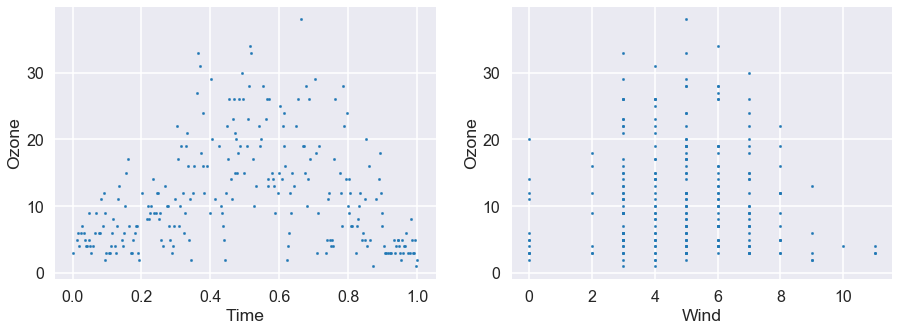

In [3]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(train.time, train.ozone, s=5)
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Ozone")
axes[1].scatter(train.wind, train.ozone, s=5)
axes[1].set_xlabel("Wind")
axes[1].set_ylabel("Ozone")
plt.show()
plt.close()

In [4]:
def Gaussian_kernel(u, h):
    '''
    Gaussian kernel evaluated at point u. Parameter h controls the bandwidth.
    '''
    
    return 1/np.sqrt(2*np.pi)*(1/h)*np.exp(-u**2/(2*h**2))

def Epa_kernel(u, h):
    '''
    Epanechnikov kernel evaluated at point u. Parameter h controls the bandwidth.
    '''
    return 3/4*(1-(u/h)**2)/h if (np.abs(u) <= h) else 0

In [5]:
def fit_kernel_regression(x, y, kernel, h=1):
    '''
    Returns a fitted model for univariate kernel regression.
    
    Arguments
    ----------
    x: np.ndarray of shape (n_samples,). Training data.
    y: np.ndarray of shape (n_samples,). Training outcomes.
    kernel: callable of the form f(x, h) --> float. Kernel function with tunable bandwidth parameter h.
    h: bandwidth parameter (default 1). Note: the default value is expected to perform poorly.
    
    Returns
    ----------
    train_mse: float. Training mean squared error.
    model: callable of the form f(x) --> float. "Fitted" model.
    '''
    
    train_predictions = prediction_helper(x, x, y, kernel, h)
    mse_train = np.mean((train_predictions - y)**2)
    
    model = get_model(x, y, kernel, h)
    
    return mse_train, model
    
def prediction_helper(x_test, x_model, y_model, kernel, h):
    '''
    Helper function to return predicted values for x_test based on training data x_model, y_model.
    '''
    
    n_samples_test = x_test.shape[0]
    n_samples_model = x_model.shape[0]
    estimations = np.zeros((n_samples_test))
    normalization = 0
    
    for idx, xi in enumerate(x_test):
        u = np.abs(x_model - xi)
        for (ui, yi) in zip(u, y):
            estimations[idx] += kernel(ui, h)*yi
            normalization += kernel(ui, h)
        estimations[idx] = estimations[idx]/normalization
        normalization = 0
        
    return estimations

def get_model(x_model, y_model, kernel, h):
    '''
    Helper function to build callable model.
    '''
    
    def model(x_test):
        return prediction_helper(x_test, x_model, y_model, kernel, h)
    
    return model

In [6]:
sigma_hat = np.std(train.time, ddof=1)
n_samples = len(train.time)
silverman_h = 1.06*sigma_hat*(n_samples)**(-1/5)

In [7]:
x = np.asarray(train.time)
y = np.asarray(train.ozone)
x_test = np.asarray(test.time)
y_test = np.asarray(test.ozone)

mse_train_Gaussian, model_Gaussian = fit_kernel_regression(x, y, Gaussian_kernel, h=silverman_h)
mse_train_Epa, model_Epa = fit_kernel_regression(x, y, Epa_kernel, h=silverman_h)

mse_test_Gauss = np.mean((model_Gaussian(x_test) - y_test)**2)
mse_test_Epa = np.mean((model_Epa(x_test) - y_test)**2)

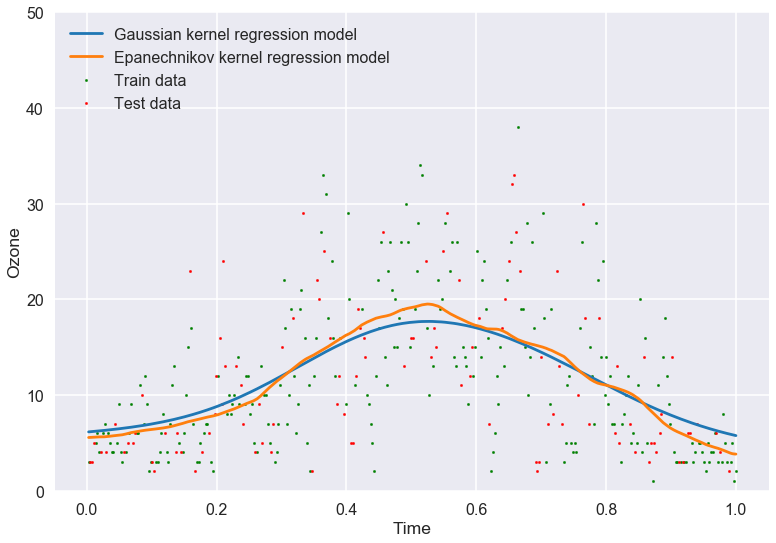

In [8]:
plt.scatter(train.time, train.ozone, s=5, c='g')
plt.scatter(test.time, test.ozone, s=5, c='r')
plt.plot(train.time, model_Gaussian(x))
plt.plot(train.time, model_Epa(x))
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.ylim([0, 50])
plt.legend(["Gaussian kernel regression model", 
            "Epanechnikov kernel regression model", 
            "Train data", 
            "Test data"], 
           loc="upper left")
plt.show()
plt.close()

In [9]:
# Report test MSE
print("Gaussian kernel regression test MSE:", mse_test_Gauss)
print("Epanechnikov kernel regression test MSE:", mse_test_Epa)

Gaussian kernel regression test MSE: 41.61847297796701
Epanechnikov kernel regression test MSE: 41.8364531226847


For the second part of the question I have to consider the following: a higher h will lead to a smoother model, which means the model will have lower variance but higher bias. On the contrary, a lower h will achieve the opposite result (rough model, low bias, high variance).

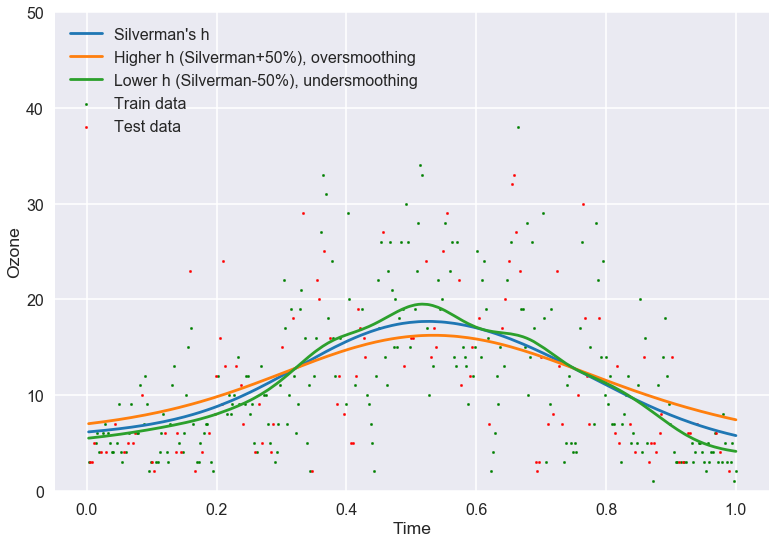

In [10]:
x = np.asarray(train.time)
y = np.asarray(train.ozone)
x_test = np.asarray(test.time)
y_test = np.asarray(test.ozone)

high_h = silverman_h*1.50
low_h = silverman_h*0.50
mse_train_Gaussian_high_h, model_Gaussian_high_h = fit_kernel_regression(x, y, Gaussian_kernel, h=high_h)
mse_train_Gaussian_low_h, model_Gaussian_low_h = fit_kernel_regression(x, y, Gaussian_kernel, h=low_h)
mse_test_Gauss_high_h = np.mean((model_Gaussian_high_h(x_test) - y_test)**2)
mse_test_Gauss_low_h = np.mean((model_Gaussian_low_h(x_test) - y_test)**2)

plt.scatter(train.time, train.ozone, s=5, c='g')
plt.scatter(test.time, test.ozone, s=5, c='r')
plt.plot(train.time, model_Gaussian(x))
plt.plot(train.time, model_Gaussian_high_h(x))
plt.plot(train.time, model_Gaussian_low_h(x))
plt.ylim([0, 50])
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.legend(["Silverman's h", 
            "Higher h (Silverman+50%), oversmoothing", 
            "Lower h (Silverman-50%), undersmoothing", 
            "Train data", 
            "Test data"], 
           loc="upper left")
plt.show()
plt.close()

In [11]:
# Report test MSE
print("Gaussian kernel regression test MSE with Silverman's h:", mse_test_Gauss)
print("Gaussian kernel regression test MSE with higher h:", mse_test_Gauss_high_h)
print("Gaussian kernel regression test MSE with lower h:", mse_test_Gauss_low_h)

Gaussian kernel regression test MSE with Silverman's h: 41.61847297796701
Gaussian kernel regression test MSE with higher h: 43.77728249853289
Gaussian kernel regression test MSE with lower h: 41.32343175608238


Interestingly, the model with lower h performs best on the test set, probably indicating that the reduction of the bias is compensating for the gain in variance.

In [12]:
x = np.asarray(train.time)
y = np.asarray(train.ozone)
x_test = np.asarray(test.time)
y_test = np.asarray(test.ozone)

# Grid of 10 values selected in log scale --> results in grid from 0.009 to 10.662
h_grid = np.logspace(-20*silverman_h, 10*silverman_h, 10) 
mse_train_grid = np.empty(10)
mse_test_grid = np.empty(10)
models_Epa_grid = []

for i, h in enumerate(h_grid):
    mse_train_grid[i], model_Epa_grid = fit_kernel_regression(x, y, Epa_kernel, h=h)
    mse_test_grid[i] = np.mean((model_Epa_grid(x_test) - y_test)**2)
    models_Epa_grid.append(model_Epa_grid)

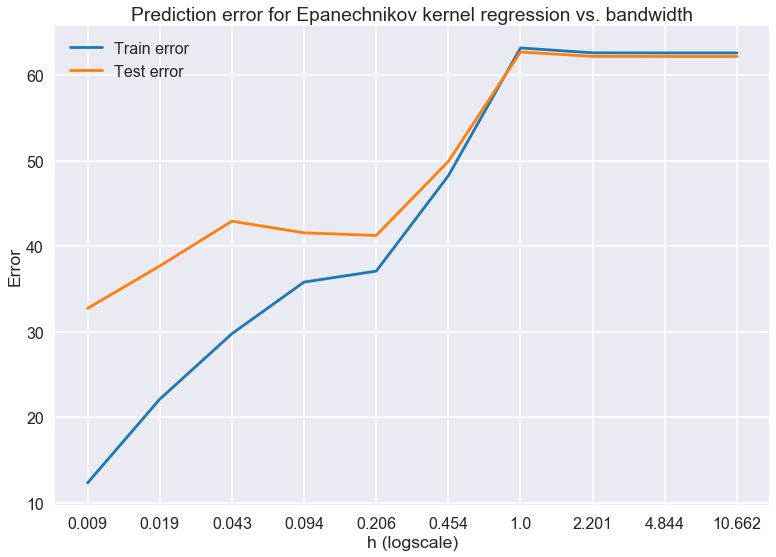

In [13]:
plt.plot(h_grid, mse_train_grid)
plt.plot(h_grid, mse_test_grid)
plt.xscale("log")
plt.xticks(h_grid, labels=h_grid.round(3))
plt.xlabel("h (logscale)")
plt.ylabel("Error")
plt.legend(["Train error", "Test error"])
plt.title("Prediction error for Epanechnikov kernel regression vs. bandwidth")
plt.show()
plt.close()

In [14]:
optimal_Epa_model = models_Epa_grid[np.argmin(mse_test_grid)]
print("Best model obtained with h =", h_grid[np.argmin(mse_test_grid)])
print("Best model test MSE:", mse_test_grid[np.argmin(mse_test_grid)])

Best model obtained with h = 0.008796263785695008
Best model test MSE: 32.75395749915019


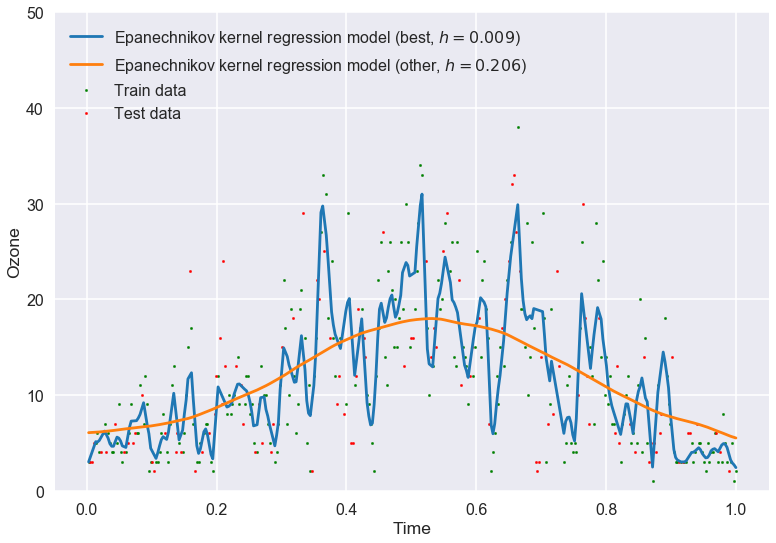

In [15]:
plt.scatter(train.time, train.ozone, s=5, c='g')
plt.scatter(test.time, test.ozone, s=5, c='r')
plt.plot(train.time, optimal_Epa_model(x))
plt.plot(train.time, models_Epa_grid[4](x))

plt.xlabel("Time")
plt.ylabel("Ozone")
plt.ylim([0, 50])
plt.legend(["Epanechnikov kernel regression model (best, $h = 0.009$)", "Epanechnikov kernel regression model (other, $h = 0.206$)", "Train data", "Test data"], loc="upper left")
plt.show()
plt.close()

It looks like the best model is overfitting the data. However, the performance of this high-variance model is better in the test set than that of a seemingly more appropriate model (labelled as "other" in the figure above).

## Question 2 [35 Points] Multi-dimensional Kernel

We consider using both `time` and `wind` in the regression. We use the following multivariate kernel function, which is essentially a Gaussian kernel with diagonal covariance matrix. 
$$ K_{\boldsymbol \lambda}(x_i, x_j) = e^{-\frac{1}{2} \sum_{k=1}^p \left((x_{ik} - x_{jk})/\lambda_k\right)^2}$$
Based on Silverman's formula, the bandwidth for the $k$th variable is given by
$$\lambda_k = \left(\frac{4}{p+2}\right)^{\frac{1}{p+4}} n^{-\frac{1}{p+4}} \, \, \widehat \sigma_k,$$
where $\widehat\sigma_k$ is the estimated standard deviation for variable $k$, $p$ is the number of variables, and $n$ is the sample size. Use the Nadaraya-Watson kernel estimator to fit and predict the `ozone` level. 

  * [25 Points] Calculate the prediction error and compare this to the univariate model in Question 1, in terms of prediction accuracy
  * [5 Points] Can you think of ways to improve two-dimensional kernel regression by using better bandwidth selection? Can the bandwidth further incorporate the covariance structure among variables? Provide some discussion on this topic, but you do not need to implement them. 
  * [5 Points] In the case of the two-dimensional kernel estimator with bandwidth $\lambda$ for both variables, if we want to extend our bias and variance derivation in the kernel lecture note, would you expect changes of rate of them? Please provide a discussion. However, you do not need to provide the proof.

In [16]:
def kernel_2D(u, h):
    '''
    Multivariate kernel function evaluated at two-dimensional vector u. 
    Parameter h (two-dimensional) controls the bandwidth.
    '''
    assert(len(h) == u.shape[0] == 2) # Avoid passing one-dimensional variable by mistake
    
    return np.exp(-np.sum((u/h)**2)*1/2)

def silverman_h_2D(x, p=2):
    '''
    Return Silverman's h for a given variable x from multivariate training data with p covariates (default 2).
    '''
    n_sample = x.shape[0]
    sigma_hat = np.std(x, ddof=1)
    factor1 = (4/(p+2))**(1/(p+4))
    factor2 = n_sample**(-1/(p+4))
    
    return factor1*factor2*sigma_hat

Please note I already implemented all the kernel regression functions in Q1 and they are compatible with multivariate kernel regression (by changing the kernel I call).

In [17]:
n_samples_train = len(train.wind)
x = np.empty((n_samples_train, 2))
x[:, 0] = np.asarray(train.time).T
x[:, 1] = np.asarray(train.wind).T
y = np.asarray(train.ozone)

n_samples_test = len(test.wind)
x_test = np.empty((n_samples_test, 2))
x_test[:, 0] = np.asarray(test.time).T
x_test[:, 1] = np.asarray(test.wind).T
y_test = np.asarray(test.ozone)

h_2D = (silverman_h_2D(train.time), silverman_h_2D(train.wind))
mse_train_multivariate, model_multivariate = fit_kernel_regression(x, y, kernel_2D, h=h_2D)

mse_test_multivariate = np.mean((y_test - model_multivariate(x_test))**2)

In [18]:
print("Multivariate training error:", mse_train_multivariate)
print("Multivariate test error:", mse_test_multivariate)

Multivariate training error: 33.91674446468615
Multivariate test error: 39.55071474041076


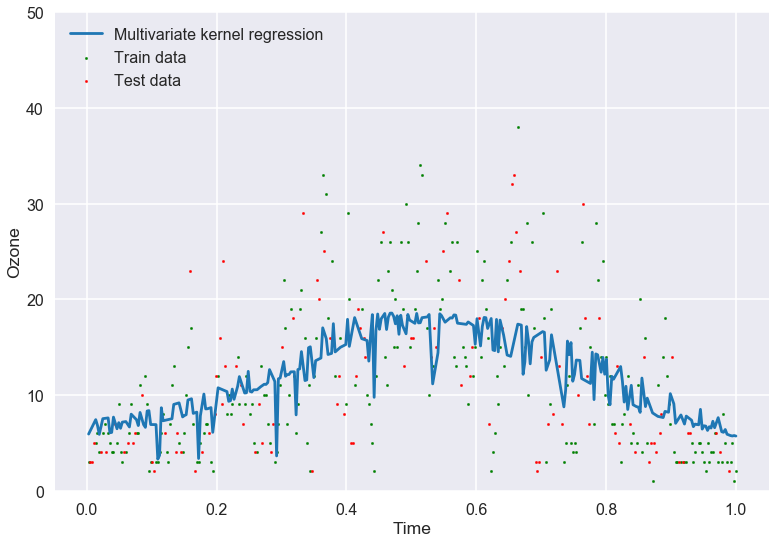

In [19]:
plt.scatter(train.time, train.ozone, s=5, c='g')
plt.scatter(test.time, test.ozone, s=5, c='r')
plt.plot(train.time, model_multivariate(x))
plt.xlabel("Time")
plt.ylabel("Ozone")
plt.ylim([0, 50])
plt.legend(["Multivariate kernel regression", "Train data", "Test data"], loc="upper left")
plt.show()
plt.close()

This model performs better than the best univariate Gaussian kernel regression but worse than the best Epanechnikov kernel regression model with the optimized bandwidth parameter. The multivariate model seems to be overfitting the data; we can see that the test error is considerably higher than the training error. Compared this difference to the difference in training and test error of unviariate kernel.

  * [5 Points] Can you think of ways to improve two-dimensional kernel regression by using better bandwidth selection? Can the bandwidth further incorporate the covariance structure among variables? Provide some discussion on this topic, but you do not need to implement them. 
 

**Answer:**

Yes. 

Instead of using a bandwidth matrix of the form

$$ \bf{H} =
\begin{pmatrix}
\lambda_1 & 0\\
0 & \lambda_2
\end{pmatrix}
$$

where $\lambda_1$ and $\lambda_2$ are bandwidth parameters derived from Silverman's rule (for each variable), we could use a symmetric positive definite matrix $\bf{H}$ that also contains off-diagonal terms so that we can control both the scale and *orientation* of the smoothing. 

Of course, this idea comes with the need to find more parameters for the bandwidth matrix. In fact, there is a "plug-in" rule to compute this matrix called the normal scale bandwidth selector defined as

$$
\mathbf{\hat H}_\mathrm{NS}=(4/(p+2))^{2/(p+4)}n^{-2/(p+4)}\bf{S}
$$

where $\boldsymbol{S}$ is the sample covariance matrix. In this way, we are incorporating the covariance structure among variables into the estimator. This bandwidth matrix can later be optimized by building an $\ell$-stage plug-in selector.

Sources I read to answer this question:
 1. https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation
 1. https://bookdown.org/egarpor/NP-UC3M/kde-ii-bwd.html#kde-ii-plug-in

 * [5 Points] In the case of the two-dimensional kernel estimator with bandwidth $\lambda$ for both variables, if we want to extend our bias and variance derivation in the kernel lecture note, would you expect changes of rate of them? Please provide a discussion. However, you do not need to provide the proof.

**Answer:**

In the lecture, we observed that, in the **univariate** case the convergence rate for the $\text{bias}^2$ term was $\mathcal{O}(\lambda^2)$ whereas it was $\mathcal{O}(1/(\lambda n))$ for the variance term. By optimizing for $\lambda$ we found that, purely as function of $n$, the convergence rate for $\text{MISE}$ was $\mathcal{O}(n^{-4/5})$.

Now, for the multivariate kernel regression case, it is expectable that the convergence rates would change. This is because we are using a higher dimensional model, and hence the complexity increases and the convergence rate should be slower. 

Although I am not presenting a proof here, it is intuitively compelling to think that we have to scale the convergence rates according to the dimensionality of our data. Say we have $p$ dimensions, then these rates would become $\mathcal{O}(\lambda^{2p})$ for $\text{bias}^2$ and $\mathcal{O}(1/(\lambda^p n))$ for the variance. For our case, where $p=2$, this is $\mathcal{O}(\lambda^{4})$ and $\mathcal{O}(1/(\lambda^2 n))$ respectively. Upon optimizing for $\lambda$, we would find that the new convergence rate for $\text{MISE}$ is $\mathcal{O}(n^{-4/(4+p)})$, which becomes $\mathcal{O}(n^{-2/3})$ for $p=2$. Thus, we can see that as we add more dimensions to our data, the conversion rate becomes very slow. This is another manifestation of the curse of dimensionality that we have seen in other cases.

Source I read for this question:
1. http://faculty.washington.edu/yenchic/17Sp_403/Lec7-density.pdf